In [1]:
import mlflow
import optuna
mlflow.set_tracking_uri("http://localhost:5000")
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)
experiment_id = get_or_create_experiment("FAKE_BERT")
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/205621345073508802', creation_time=1717291921234, experiment_id='205621345073508802', last_update_time=1717291921234, lifecycle_stage='active', name='FAKE_BERT', tags={}>

In [2]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [3]:
import pandas as pd
train = pd.concat([pd.read_csv("fake_train_balanced_indexed.csv"), pd.read_csv("fake_train_full_paraphrased_aug_indexed_balanced_llama3.csv")]).reset_index()
# pd.read_csv("fake_train_inc_full_backtranslated_aug_indexed_balanced_v1.csv"), pd.read_csv("fake_train_full_paraphrased_aug_indexed_balanced_llama3.csv")
validate = pd.read_csv("fake_validate_balanced_indexed.csv")

In [4]:
from tensorflow import keras
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
from tensorflow.keras.metrics import Precision, Recall
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
import glob
import json
import os
class HEnconde(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        json.JSONEncoder.default(self, obj)
def train_model(params, callbacks):
    #https://github.com/tensorflow/tensorflow/issues/56661
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )
    tf.keras.utils.set_random_seed(5113)
    MAX_LEN = params["maxlen"]
    train_tensor_input = []
    train_tensor_attention_mask = []
    train_inputs = [tokenizer.encode_plus(message, max_length=MAX_LEN,truncation=True,pad_to_max_length=True, add_special_tokens=True, return_attention_mask=True) for message in train["text"].values]
    for train_input in train_inputs:
      train_tensor_input.append(train_input["input_ids"])
      train_tensor_attention_mask.append(train_input["attention_mask"])
    train_tensor_input = tf.convert_to_tensor(train_tensor_input)
    train_tensor_attention_mask = tf.convert_to_tensor(train_tensor_attention_mask)
    validate_tensor_input = []
    validate_tensor_attention_mask = []
    validate_inputs = [tokenizer.encode_plus(message, max_length=MAX_LEN,truncation=True,pad_to_max_length=True, add_special_tokens=True, return_attention_mask=True) for message in validate["text"].values]
    for validate_input in validate_inputs:
      validate_tensor_input.append(validate_input["input_ids"])
      validate_tensor_attention_mask.append(validate_input["attention_mask"])
    validate_tensor_input = tf.convert_to_tensor(validate_tensor_input)
    validate_tensor_attention_mask = tf.convert_to_tensor(validate_tensor_attention_mask)

    model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=1)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(learning_rate=params["learning_rate"], epsilon = params["epsilon"])
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",Precision(), Recall()])#, Precision(), Recall()
    history = model.fit((train_tensor_input, train_tensor_attention_mask), tf.convert_to_tensor(train["misinformation"].values, dtype=tf.float32), batch_size=params['batch_size'], epochs=params['epochs'], validation_data=([validate_tensor_input, validate_tensor_attention_mask], tf.convert_to_tensor(validate["misinformation"], dtype=tf.float32)), callbacks=callbacks)
    best_acc_i = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    metrics = []
    for metric_name in model.metrics_names:
        metrics.append(history.history["val_" + metric_name][best_acc_i])
    for best_m in glob.glob("best_bert_*.h5"):
        if float(best_m[:-3].replace("best_bert_", "")) < float(history.history['val_accuracy'][best_acc_i]):
            model.save_weights(f"best_bert_{str(history.history['val_accuracy'][best_acc_i])}.h5")
            os.remove(best_m)
            with open(f"best_bert_history.json", "w")as f:
                f.write(json.dumps(dict(history.history), indent=4, cls=HEnconde))
    return [best_acc_i, zip(model.metrics_names, metrics)]


2024-07-01 10:04:58.153124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 10:04:58.153170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 10:04:58.154173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 10:04:58.161899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 10:04:58.910522: W tensorflow/compiler/tf2

In [5]:
import itertools
import gc
from numba import cuda 
import sys
from multiprocessing import Queue, Process
from optuna.integration import TFKerasPruningCallback
from typing import Optional
from typing import Any
from typing import Dict
import tensorflow
class TFKerasPruningCallback(TFKerasPruningCallback):
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.best_weights = None
        self.best_acc = 0
    
    def on_epoch_end(self, epoch: int, logs: Optional[Dict[str, Any]] = None) -> None:
        logs = logs or {}
        current_score = logs.get(self._monitor)
        if float(self.best_acc) < float(current_score):
            self.best_acc = current_score
            self.best_weights = self.model.get_weights()
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self._monitor)
            )
            warnings.warn(message)
            return

        # Report current score and epoch to Optuna's trial.
        self._trial.report(float(current_score), step=epoch)

        # Prune trial if needed
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            self.model.stop_training = True
            #raise optuna.TrialPruned(message)
    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
    


#https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
def process_run(func, params, callbacks):
    def wrapper_func(queue, params, callbacks):
        try:
            result = func(params, callbacks)
            error = None
        except Exception:
            result = None
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value
        queue.put((result, error))

    def process(params, callbacks):
        queue = Queue()
        p = Process(target = wrapper_func, args = [queue] + [params] + [callbacks])
        p.start()
        result, error = queue.get()
        p.join()
        return result, error  

    result, error = process(params, callbacks)
    return result, error


def objective(trial, study):
    # Define hyperparameters
    params = {
        "learning_rate": 1e-4, #trial.suggest_float("learning_rate", 1e-4, 1e-3),
        "epsilon": 1e-8,#trial.suggest_float("epsilon", 1e-8, 1e-6),
        "maxlen": trial.suggest_int("maxlen", 96, 160, step=32),
        "epochs": 20, #trial.suggest_int("epochs", 2, 12, step=2)
        "batch_size":trial.suggest_int("batch_size", 16, 24, step=8)
    }
    callbacks = [TFKerasPruningCallback(trial, "val_accuracy"), tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=0, mode="max", restore_best_weights=True)]
    #TFKerasPruningCallback(trial, "val_accuracy")
    #tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=0, mode="max"), 
    with mlflow.start_run(nested=True, run_name=f"BERT_MODEL_PARA_AUG_lr_{params['learning_rate']}_eps_{params['epsilon']}_maxlen_{params['maxlen']}_epochs_{params['epochs']}_bs_{params['batch_size']}"):
        metrics, error = process_run(train_model, params=params, callbacks=callbacks)
        print(error)
        #metrics = train_model(params, callbacks)
        # Log to MLflow
        params["epochs"] = metrics[0] + 1
        mlflow.log_params(params)
        metrics = list(metrics[1])
        metrics = dict(metrics)
        partial_f1 = (metrics["precision"] + metrics["recall"])
        partial_f1 = partial_f1 if partial_f1 else 1
        metrics["f1_score"] =  2 * (metrics["precision"] * metrics["recall"]) / partial_f1
        for metric in metrics:
            mlflow.log_metric(metric, metrics[metric])
        print(dict(metrics))
    return metrics["accuracy"]
        #best_acc = []
        #for i in range(params["epochs"]):
        #    best_acc.append(i, trial.intermediate_values[i])
        #best_acc = max(best_acc, key = lambda x: x[1])
        #params["epochs"] = best_acc[0] + 1
        #mlflow.log_params(params)
        #if not metrics and best_acc <= best_value:
        #    print(params, error)
        #    raise optuna.TrialPruned()
        #mlflow.log_metric("accuracy", best_acc)
    #return best_acc
        

In [7]:
with mlflow.start_run(experiment_id=experiment_id, run_name="BERT_MODEL_PARA_AUG"):
    # Initialize the Optuna study
    pruner = optuna.pruners.HyperbandPruner(min_resource=2, max_resource=20, reduction_factor=3)
    #sampler=optuna.samplers.TPESampler(multivariate=True)
    sampler=optuna.samplers.BruteForceSampler()
    study_name = "BERT_MODEL_PARA_AUG_V13"  # Unique identifier of the study.
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(
        direction="maximize",
        pruner=pruner,
        sampler=sampler,
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True
    )

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    complete_trials = 0
    #while complete_trials < 9:
    study.optimize(lambda x: objective(x, study), n_trials=6, callbacks=[champion_callback])
        #complete_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_accuracy", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "FAKE_NEWS",
            "optimizer_engine": "optuna",
            "model_family": "BERT",
            "feature_set_version": 1,
        }
    )

/tmp/ipykernel_26323/3150942913.py:5: ExperimentalWarning: BruteForceSampler is experimental (supported from v3.1.0). The interface can change in the future.
  sampler=optuna.samplers.BruteForceSampler()
[I 2024-07-01 16:39:45,926] A new study created in RDB with name: BERT_MODEL_PARA_AUG_V13
/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 16:39:46.247631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/device

Epoch 1/20


2024-07-01 16:40:48.489455: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcebcacf370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 16:40:48.489500: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 16:40:48.496330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 16:40:48.515895: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719862848.580600   24909 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


893/893 [==============================] - 1690s 2s/step - loss: 0.3557 - accuracy: 0.8243 - precision: 0.8739 - recall: 0.7977 - val_loss: 0.4390 - val_accuracy: 0.8029 - val_precision: 0.8391 - val_recall: 0.7494
Epoch 2/20
893/893 [==============================] - 1619s 2s/step - loss: 0.1988 - accuracy: 0.9171 - precision: 0.9389 - recall: 0.9092 - val_loss: 0.4015 - val_accuracy: 0.8373 - val_precision: 0.8163 - val_recall: 0.8705
Epoch 3/20
893/893 [==============================] - 1617s 2s/step - loss: 0.1563 - accuracy: 0.9398 - precision: 0.9556 - recall: 0.9346 - val_loss: 0.5050 - val_accuracy: 0.8005 - val_precision: 0.7799 - val_recall: 0.8373
Epoch 4/20
893/893 [==============================] - 1621s 2s/step - loss: 0.1265 - accuracy: 0.9525 - precision: 0.9652 - recall: 0.9483 - val_loss: 0.5470 - val_accuracy: 0.8011 - val_precision: 0.7483 - val_recall: 0.9074


[I 2024-07-01 18:29:31,565] Trial 0 finished with value: 0.8372921347618103 and parameters: {'maxlen': 160, 'batch_size': 24}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.401524156332016, 'accuracy': 0.8372921347618103, 'precision': 0.8162583708763123, 'recall': 0.8705463409423828, 'f1_score': 0.8425287563535587}
Initial trial 0 achieved value: 0.8372921347618103


/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 18:29:31.930242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 18:29:31.931512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Epoch 1/20


2024-07-01 18:30:27.428006: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fceac308430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 18:30:27.428052: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 18:30:27.434652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 18:30:27.453355: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719869427.512547    7943 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


893/893 [==============================] - 1139s 1s/step - loss: 0.3712 - accuracy: 0.8183 - precision: 0.8713 - recall: 0.7881 - val_loss: 0.4672 - val_accuracy: 0.8076 - val_precision: 0.7797 - val_recall: 0.8575
Epoch 2/20
893/893 [==============================] - 1051s 1s/step - loss: 0.2063 - accuracy: 0.9167 - precision: 0.9390 - recall: 0.9084 - val_loss: 0.4153 - val_accuracy: 0.8195 - val_precision: 0.7880 - val_recall: 0.8741
Epoch 3/20
893/893 [==============================] - 1013s 1s/step - loss: 0.1260 - accuracy: 0.9530 - precision: 0.9643 - recall: 0.9503 - val_loss: 0.6179 - val_accuracy: 0.7993 - val_precision: 0.8663 - val_recall: 0.7078
Epoch 4/20
893/893 [==============================] - 1044s 1s/step - loss: 0.1736 - accuracy: 0.9342 - precision: 0.9484 - recall: 0.9318 - val_loss: 0.6317 - val_accuracy: 0.7838 - val_precision: 0.7371 - val_recall: 0.8824


[I 2024-07-01 19:40:53,494] Trial 1 finished with value: 0.8194774389266968 and parameters: {'maxlen': 128, 'batch_size': 24}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.4153331220149994, 'accuracy': 0.8194774389266968, 'precision': 0.7880085706710815, 'recall': 0.8741092681884766, 'f1_score': 0.8288288338306532}


/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 19:40:53.787800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 19:40:53.789092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Epoch 1/20


2024-07-01 19:41:48.177451: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcebf84f830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 19:41:48.177554: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 19:41:48.184154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 19:41:48.202077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719873708.260565   29441 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1339/1339 [==============================] - 1716s 1s/step - loss: 0.3862 - accuracy: 0.8102 - precision: 0.8635 - recall: 0.7803 - val_loss: 0.4167 - val_accuracy: 0.8034 - val_precision: 0.8135 - val_recall: 0.7874
Epoch 2/20
1339/1339 [==============================] - 1694s 1s/step - loss: 0.3437 - accuracy: 0.7992 - precision: 0.9072 - recall: 0.7097 - val_loss: 0.6984 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
1339/1339 [==============================] - 1720s 1s/step - loss: 0.6889 - accuracy: 0.4518 - precision: 0.5804 - recall: 0.0335 - val_loss: 0.6943 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


[I 2024-07-01 21:06:58,672] Trial 2 finished with value: 0.8034442067146301 and parameters: {'maxlen': 160, 'batch_size': 16}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.4166751503944397, 'accuracy': 0.8034442067146301, 'precision': 0.8134969472885132, 'recall': 0.7874109148979187, 'f1_score': 0.8002414013462029}


/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 21:06:58.957022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 21:06:58.958371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Epoch 1/20


2024-07-01 21:07:57.486203: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fceb2a1fd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 21:07:57.486260: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 21:07:57.495304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 21:07:57.516361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719878877.596421   13230 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


893/893 [==============================] - 1100s 1s/step - loss: 0.3718 - accuracy: 0.8174 - precision: 0.8683 - recall: 0.7899 - val_loss: 0.4128 - val_accuracy: 0.8124 - val_precision: 0.8497 - val_recall: 0.7589
Epoch 2/20
893/893 [==============================] - 1466s 2s/step - loss: 0.1992 - accuracy: 0.9197 - precision: 0.9392 - recall: 0.9140 - val_loss: 0.6396 - val_accuracy: 0.8040 - val_precision: 0.7452 - val_recall: 0.9240
Epoch 3/20
893/893 [==============================] - 1465s 2s/step - loss: 0.1320 - accuracy: 0.9493 - precision: 0.9639 - recall: 0.9437 - val_loss: 0.6781 - val_accuracy: 0.7916 - val_precision: 0.8760 - val_recall: 0.6793


[I 2024-07-01 22:14:47,773] Trial 3 finished with value: 0.8123515248298645 and parameters: {'maxlen': 96, 'batch_size': 24}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.41277235746383667, 'accuracy': 0.8123515248298645, 'precision': 0.8497340679168701, 'recall': 0.7589073777198792, 'f1_score': 0.8017566064720888}


/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 22:14:48.074249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 22:14:48.075566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Epoch 1/20


2024-07-01 22:15:45.571387: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcecde74560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 22:15:45.571433: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 22:15:45.577885: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 22:15:45.596111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719882945.654517   24978 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1339/1339 [==============================] - 624s 441ms/step - loss: 0.4061 - accuracy: 0.7967 - precision: 0.8509 - recall: 0.7670 - val_loss: 0.4826 - val_accuracy: 0.7833 - val_precision: 0.8008 - val_recall: 0.7542
Epoch 2/20
1339/1339 [==============================] - 591s 441ms/step - loss: 0.2426 - accuracy: 0.8972 - precision: 0.9271 - recall: 0.8837 - val_loss: 0.5838 - val_accuracy: 0.7797 - val_precision: 0.7105 - val_recall: 0.9442
Epoch 3/20
1339/1339 [==============================] - 591s 442ms/step - loss: 0.4386 - accuracy: 0.6892 - precision: 0.8752 - recall: 0.5112 - val_loss: 0.6976 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


[I 2024-07-01 22:45:31,135] Trial 4 finished with value: 0.7832541465759277 and parameters: {'maxlen': 96, 'batch_size': 16}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.4826309382915497, 'accuracy': 0.7832541465759277, 'precision': 0.8007566332817078, 'recall': 0.754156768321991, 'f1_score': 0.7767584151571234}


/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-07-01 22:45:31.440999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 22:45:31.442275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Epoch 1/20


2024-07-01 22:46:27.766057: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcec2789c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 22:46:27.766102: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-07-01 22:46:27.772326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 22:46:27.790171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719884787.847984    6642 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1339/1339 [==============================] - 838s 601ms/step - loss: 0.3966 - accuracy: 0.8068 - precision: 0.8563 - recall: 0.7821 - val_loss: 0.4687 - val_accuracy: 0.7951 - val_precision: 0.8042 - val_recall: 0.7803
Epoch 2/20
1339/1339 [==============================] - 804s 600ms/step - loss: 0.2364 - accuracy: 0.9022 - precision: 0.9272 - recall: 0.8935 - val_loss: 0.5017 - val_accuracy: 0.8070 - val_precision: 0.7603 - val_recall: 0.8967
Epoch 3/20
1339/1339 [==============================] - 803s 600ms/step - loss: 0.1634 - accuracy: 0.9372 - precision: 0.9543 - recall: 0.9312 - val_loss: 0.6822 - val_accuracy: 0.7815 - val_precision: 0.7342 - val_recall: 0.8824
Epoch 4/20
1339/1339 [==============================] - 802s 599ms/step - loss: 0.6458 - accuracy: 0.5003 - precision: 0.8115 - recall: 0.1264 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


[I 2024-07-01 23:40:13,071] Trial 5 finished with value: 0.8070071339607239 and parameters: {'maxlen': 128, 'batch_size': 16}. Best is trial 0 with value: 0.8372921347618103.


None
{'loss': 0.5016971826553345, 'accuracy': 0.8070071339607239, 'precision': 0.7603222727775574, 'recall': 0.8966745734214783, 'f1_score': 0.8228882887369998}


In [4]:
import tensorflow
params = {
    "learning_rate": 0.0001,
    "epsilon": 1e-8,
    "maxlen": 128,
    "epochs": 1, #trial.suggest_int("epochs", 2, 12, step=2)
    "batch_size": 16
}
model = train_model(params, [tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=0, mode="max", restore_best_weights=True)])

2024-07-01 07:31:51.648515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 07:31:51.649549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 07:31:51.649613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, o

1339/1339 [==============================] - 887s 633ms/step - loss: 0.4014 - accuracy: 0.7998 - precision: 0.8538 - recall: 0.7701 - val_loss: 0.4102 - val_accuracy: 0.7963 - val_precision: 0.8685 - val_recall: 0.6983


In [12]:
model.save_weights('bert_model_best.h5')


In [8]:
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
)
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=1)
model.load_weights('best_bert_0.8372921347618103.h5')

2024-07-02 03:39:56.903113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 03:39:56.909624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 03:39:56.909722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 03:39:57.458787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 03:39:57.458898: I external/local_xla/xla/stream_executor

In [1]:
import pandas as pd
test = pd.read_csv("fake_test_balanced_indexed.csv")
test

,Unnamed: 0,text,misinformation,index
0,3722,O PT convocou todos os macumbeiros do Brasil e...,1,3722
1,16059,"“Bem, acredito que esteje tudo bem com você, a...",1,16059
2,13247,“Laudo médico rompimento da artéria devido o e...,1,13247
3,11255,… Já está sendo vendida em outros Estados e es...,1,11255
4,15979,Na Argentina ta tudo normal! STF da Argentina ...,1,15979
...,...,...,...,...
1679,6283,￼\n\nGeneral Paulo Chagas alerta Ciro Gomes\n\...,0,6283
1680,6707,moradores da cidade argentina santiago del est...,0,6707
1681,4081,Montes claros parou pra gritar 17.\nÉ só o com...,0,4081
1682,14727,A atriz da Globo teve um vídeo vazado na inter...,0,14727


In [2]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from transformers import pipeline
import sys
from multiprocessing import Queue, Process
from typing import Optional
from typing import Any
from typing import Dict
def process_run(func, texts):
    def wrapper_func(queue, texts):
        try:
            result = func(texts)
            error = None
        except Exception:
            result = None
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value
        queue.put((result, error))

    def process(texts):
        queue = Queue()
        p = Process(target = wrapper_func, args = [queue] + [texts])
        p.start()
        result, error = queue.get()
        p.join()
        return result, error  

    result, error = process(texts)
    return result, error
def classify(text):
    import tensorflow as tf
    from transformers import AutoTokenizer, TFBertForSequenceClassification
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )
    tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
    model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=1)
    model.load_weights('best_bert_0.8372921347618103.h5')
    classifier = pipeline(task="text-classification", model=model, top_k=None, tokenizer=tokenizer)
    for i, item in enumerate(text):
        if len(item) > 20000:
            text[i] = item[:20000]
    return classifier(list(text))

2024-07-02 03:40:32.435390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 03:40:32.435440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 03:40:32.436406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 03:40:32.442345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 03:40:33.510973: W tensorflow/compiler/tf2

In [ ]:
test_texts = list(test["text"].values)

classify_all = process_run(classify, test_texts)

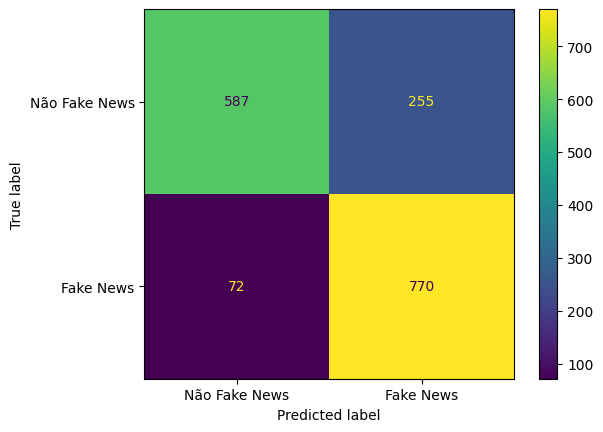

In [10]:
pred_labels = []
for classification in classify_all[0]:
  if classification[0]['score'] >= 0.5:
    pred_labels.append(1)
  else:
    pred_labels.append(0)

confusion_matrix = metrics.confusion_matrix(test["misinformation"].values, pred_labels)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Não Fake News", "Fake News"])

cm_display.plot()
plt.show()

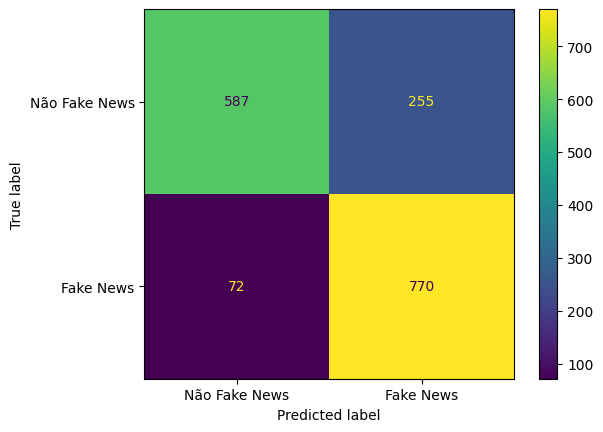

In [16]:
#old_test = pd.read_csv("drive/MyDrive/test_fake.csv")
##classifier = pipeline(task="text-classification", model=model, top_k=None, tokenizer=tokenizer)
#classify_all_old = classifier(list(old_test["text"].values))
#
#pred_labels = []
#for classification in classify_all_old:
#  label0 = 0
#  label1 = 0
#  for label in classification:
#    if label["label"] == "LABEL_0":
#      label0=label["score"]
#    if label["label"] == "LABEL_1":
#      label1=label["score"]
#  if label0 > label1:
#    pred_labels.append(0)
#  else:
#    pred_labels.append(1)

confusion_matrix = metrics.confusion_matrix(test["misinformation"].values, pred_labels)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Não Fake News", "Fake News"])

cm_display.plot()
plt.savefig('bert_results.png')

plt.show()

In [11]:
from sklearn.metrics import classification_report
target_names = ["0", "1"]
print(classification_report(test["misinformation"].map(lambda x: str(x)).values, [ str(x) for x in pred_labels], target_names=target_names))

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       842
           1       0.75      0.91      0.82       842

    accuracy                           0.81      1684
   macro avg       0.82      0.81      0.80      1684
weighted avg       0.82      0.81      0.80      1684



In [12]:
metrics.precision_recall_fscore_support(test["misinformation"].values, pred_labels, average=None, labels=[0, 1])

(array([0.89074355, 0.75121951]),
 array([0.69714964, 0.91448931]),
 array([0.78214524, 0.8248527 ]),
 array([842, 842]))

In [13]:
metrics.accuracy_score(test["misinformation"].values, pred_labels, normalize=True)


0.8058194774346793

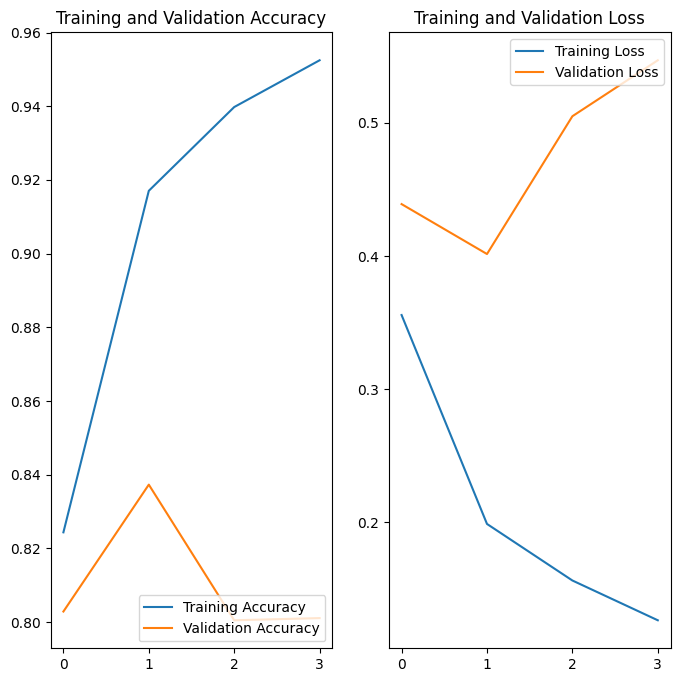

In [17]:
import matplotlib.pyplot as plt
import json
with open("best_bert_history.json", "r") as f:
    history = json.loads(f.read())

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(len(history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('val_acc_bert.png')
plt.show()